### **1. Libraries and Configurations**
----

In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import product

In [3]:
# Machine Learning
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, PrecisionRecallDisplay, f1_score
from sklearn.calibration import calibration_curve

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### **2. Importing Dataset**
----

In [5]:
df = pd.read_csv('startup_failure_prediction.csv', encoding='ISO-8859-1')
df.head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,New York,1.0,2012-06-01,2012-06,2012-Q2,2012.0,2012-06-30,2012-06-30,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,Los Angeles,2.0,NaN,NaN,NaN,NaN,2010-06-04,2010-09-23,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,Tallinn,1.0,2012-10-26,2012-10,2012-Q4,2012.0,2012-08-09,2012-08-09,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,London,1.0,2011-04-01,2011-04,2011-Q2,2011.0,2011-04-01,2011-04-01,1500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,Fort Worth,2.0,2014-01-01,2014-01,2014-Q1,2014.0,2014-08-17,2014-09-26,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **3. Dataset Validation**
----

In [6]:
print(f'The dataset have {df.shape[1]} columns and {df.shape[0]} rows.')

The dataset have 39 columns and 54294 rows.


In [7]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [8]:
# Let's drop the non-usable columns

drop = ['permalink', 'name', 'homepage_url', 'category_list',
        'founded_month', 'founded_quarter', 'founded_year']

for col in drop:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

In [9]:
# The goal is to predict whether a startup failed (closed) or succeeded (acquired).
# We restrict the dataset to these two outcomes and encode them into a binary target variable.

df = df[df['status'].isin(['acquired', 'closed'])].copy()
df['failed'] = df['status'].map({'closed': 1, 'acquired': 0})
df.drop('status', axis=1, inplace=True)
df['failed'].value_counts()

failed
0    3692
1    2603
Name: count, dtype: int64

In [10]:
print(f'The dataset have {df.shape[1]} columns and {df.shape[0]} rows.\n')

The dataset have 32 columns and 6295 rows.



### **4. Data Cleaning & Preprocessing**
----

#### **4.1. Ajust in the Main Columns**
----

In [11]:
df_clean = df.copy()

In [12]:
# Converting to datetime the founded_at column:

df_clean['founded_at'] = pd.to_datetime(df_clean['founded_at'], errors='coerce')
df_clean['first_funding_at'] = pd.to_datetime(df_clean['first_funding_at'], errors='coerce')
df_clean['last_funding_at'] = pd.to_datetime(df_clean['last_funding_at'], errors='coerce')

In [13]:
# Standardizing the funding_total_usd column:

df_clean['funding_total_usd'] = df_clean['funding_total_usd'].str.strip().str.lower().str.replace(',', '')
df_clean['funding_total_usd'] = pd.to_numeric(df_clean['funding_total_usd'], errors='coerce')

In [14]:
# If the startup is not from the USA, mark its state_code and country_code as 'FGN' (foreign):

df_clean.loc[df_clean['country_code'] != 'USA', 'state_code'] = 'FGN'
df_clean.loc[df_clean['country_code'] != 'USA', 'country_code'] = 'FGN'


In [15]:
# Let's drop region/city column. It's too cardinality:

drop = ['region', 'city']

for col in drop:
    if col in df_clean.columns:
        df_clean.drop(columns=col, inplace=True)

#### **4.2. Treatment of Null Values**
----

In [16]:
null_cols = df_clean.isnull().sum()
null_cols = null_cols[null_cols > 0]
null_cols

market                231
funding_total_usd     919
founded_at           1323
first_funding_at        1
dtype: int64

In [17]:
# Remove rows with missing or invalid 'first_funding_at':

df_clean = df_clean.dropna(subset=['first_funding_at'])

In [18]:
# Replacing missing with 'Unknown':

df_clean['market'] = df_clean['market'].fillna('Unknown')

In [19]:
# Creating a flag for missing founded_at:

df_clean['founded_missing'] = df_clean['founded_at'].isna().astype(int)

# Extracting year and month:

df_clean['founded_year'] = df_clean['founded_at'].dt.year
df_clean['founded_month'] = df_clean['founded_at'].dt.month

df_clean['first_funding_year'] = df_clean['first_funding_at'].dt.year
df_clean['first_funding_month'] = df_clean['first_funding_at'].dt.month

df_clean['last_funding_year'] = df_clean['last_funding_at'].dt.year
df_clean['last_funding_month'] = df_clean['last_funding_at'].dt.month

# Filling missing founded_year with median and founded_month with mode:

df_clean['founded_year'] = df_clean['founded_year'].fillna(df_clean['founded_year'].median())
df_clean['founded_month'] = df_clean['founded_month'].fillna(df_clean['founded_month'].mode()[0])

In [20]:
# Filling missing with 0 (no funding):

df_clean['funding_total_usd'] = df_clean['funding_total_usd'].fillna(0)

#### **4.3. Initial Feature Engineering**
----

In [21]:
# Calculate months between founded_at and first funding:

df_clean['months_to_first_funding'] = ((df_clean['first_funding_at'] - pd.to_datetime(df_clean['founded_year'].astype(int).astype(str) 
                                                                                      + '-' 
                                                                                      + df_clean['founded_month'].astype(int).astype(str) + '-01')) 
                                       / pd.Timedelta(days=30)).round(1)

In [22]:
# Calculate months between first and last funding:

df_clean['funding_duration_months'] = ((df_clean['last_funding_at'] - df_clean['first_funding_at']) / pd.Timedelta(days=30)).round(1)

In [23]:
df_clean.drop(['first_funding_at', 'last_funding_at', 'founded_at'], axis=1, inplace=True)

In [24]:
categorical = []
numerical = []

for col in df_clean.columns:
    if col == 'failed':
        continue
    if df_clean[col].dtype == 'object':
        categorical.append(col)
    else:
        numerical.append(col)

print("Categorical columns:", categorical)
print("Numerical columns:", numerical)


Categorical columns: ['market', 'country_code', 'state_code']
Numerical columns: ['funding_total_usd', 'funding_rounds', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_a', 'round_b', 'round_c', 'round_d', 'round_e', 'round_f', 'round_g', 'round_h', 'founded_missing', 'founded_year', 'founded_month', 'first_funding_year', 'first_funding_month', 'last_funding_year', 'last_funding_month', 'months_to_first_funding', 'funding_duration_months']


### **5. Feature Engineering**
----

In [25]:
# Remove startups founded before 2000, as they are few and too old for this analysis:

df_clean = df_clean[df_clean['founded_year'] >= 2000]

df_final = df_clean.copy()

In [26]:
df_final = df_final[
    (df_final['first_funding_year'] >= df_final['founded_year']) &
    (df_final['last_funding_year'] >= df_final['first_funding_year']) &
    (df_final['months_to_first_funding'] >= 0)
]

#### **5.1. Categorical Features**
----

In [27]:
for col in categorical:
    df_final[col] = df_final[col].str.strip().str.lower().str.replace(' ', '_')

In [28]:
for col in categorical:
    print(f'Feature: {col}.')
    print(f'- Number of Categories: {df_final[col].nunique()}.')
    print(f'- Categories: {df_final[col].unique()}.')

Feature: market.
- Number of Categories: 380.
- Categories: ['news' 'advertising' 'marketplaces' 'analytics' 'curated_web'
 'e-commerce' 'lifestyle' 'finance' 'software' 'unknown'
 'electronic_health_records' 'games' 'semiconductors' 'web_hosting'
 'android' 'security' 'cloud_computing' 'automotive' 'photography' 'video'
 'internet_marketing' 'music' 'social_media' 'task_management'
 'virtual_worlds' 'public_relations' 'mobile' 'restaurants' 'seo'
 'biotechnology' 'health_care' 'career_management' 'vertical_search'
 'telecommunications' 'clean_technology' 'enterprise_software'
 'social_media_advertising' 'television' 'publishing'
 'facebook_applications' 'location_based_services' 'industrial'
 'entertainment' 'sales_and_marketing' 'health_and_wellness'
 'local_based_services' 'internet' 'auctions' 'displays' 'social_commerce'
 'clean_energy' 'hardware_+_software' 'saas' 'web_cms' 'wireless' 'iphone'
 'cloud_infrastructure' 'lighting' 'credit' 'web_development'
 'data_mining' 'sports' '

In [29]:
# Display top markets and cumulative percentage
# Helps to decide how many top categories to keep and group the rest as 'Other'

market_counts = df_final['market'].value_counts()

market_perc = market_counts / market_counts.sum() * 100

market_summary = pd.DataFrame({
    'count': market_counts,
    'percent': market_perc,
    'cumulative_percent': market_perc.cumsum()
})

market_summary.head(25) 


,count,percent,cumulative_percent
market,,,
software,492,10.108897,10.108897
curated_web,386,7.930964,18.039860
mobile,279,5.732484,23.772344
biotechnology,246,5.054448,28.826793
games,189,3.883296,32.710088
enterprise_software,188,3.862749,36.572837
advertising,186,3.821656,40.394494
e-commerce,143,2.938155,43.332648
social_media,129,2.650503,45.983152


In [30]:
# Keep top 25 most frequent markets (~70% coverage) and replace the rest with 'Other':

top_markets = df_final['market'].value_counts().head(25).index
df_final['market'] = df_final['market'].apply(lambda x: x if x in top_markets else 'other')

In [31]:
state_counts = df_final['state_code'].value_counts()

state_perc = state_counts / state_counts.sum() * 100

state_summary = pd.DataFrame({
    'count': state_counts,
    'percent': state_perc,
    'cumulative_percent': state_perc.cumsum()
})

state_summary.head(12)


,count,percent,cumulative_percent
state_code,,,
fgn,1585,32.566263,32.566263
ca,1565,32.155332,64.721594
ny,352,7.232381,71.953976
ma,248,5.095541,77.049517
wa,140,2.876515,79.926032
tx,136,2.794329,82.720362
co,84,1.725909,84.446271
pa,77,1.582083,86.028354
il,64,1.314978,87.343333


In [32]:
# Keep top 12 most frequent markets (~90% coverage) and replace the rest with 'Other':

top_states = df_final['state_code'].value_counts().head(12).index
df_final['state_code'] = df_final['state_code'].apply(lambda x: x if x in top_states else 'other')

In [33]:
for col in categorical:
    print(f'Feature: {col}.')
    print(f'- Number of Categories: {df_final[col].nunique()}.')

Feature: market.
- Number of Categories: 26.
Feature: country_code.
- Number of Categories: 2.
Feature: state_code.
- Number of Categories: 13.


#### **5.2. Numerical Features**
----

In [34]:
df_final[numerical].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99]).T

,count,mean,std,min,25%,50%,75%,90%,99%,max
funding_total_usd,4867.0,1.409167e+07,9.552139e+07,0.0,180000.0,2100000.0,10884550.00,31000000.00,1.250850e+08,5.700000e+09
funding_rounds,4867.0,1.764331e+00,1.238568e+00,1.0,1.0,1.0,2.00,3.00,6.000000e+00,1.100000e+01
seed,4867.0,1.786653e+05,6.830466e+05,0.0,0.0,0.0,0.00,500000.00,3.000000e+06,2.100000e+07
venture,4867.0,9.769016e+06,2.529395e+07,0.0,0.0,1232849.0,10000000.00,28000000.00,9.771431e+07,7.750000e+08
equity_crowdfunding,4867.0,1.633450e+03,8.601264e+04,0.0,0.0,0.0,0.00,0.00,0.000000e+00,5.500000e+06
undisclosed,4867.0,2.549442e+04,4.867610e+05,0.0,0.0,0.0,0.00,0.00,0.000000e+00,1.652408e+07
convertible_note,4867.0,7.693199e+03,2.143272e+05,0.0,0.0,0.0,0.00,0.00,0.000000e+00,1.352014e+07
debt_financing,4867.0,1.276701e+06,2.428702e+07,0.0,0.0,0.0,0.00,0.00,1.318491e+07,1.200000e+09
angel,4867.0,7.773591e+04,6.326902e+05,0.0,0.0,0.0,0.00,0.00,1.522440e+06,3.000000e+07
grant,4867.0,1.460673e+04,3.977024e+05,0.0,0.0,0.0,0.00,0.00,5.050000e+03,2.400000e+07


In [35]:
# We will agregate all funding-related columns to:
# 1. Calculate total investment per startup
# 2. Create binary flags indicating if the startup received each type of funding

# List of investment-related columns:

investment_cols = [
    'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note',
    'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity',
    'post_ipo_debt', 'secondary_market', 'product_crowdfunding'
]

# The column funding_total_usd is the sum of all these columns

In [36]:
# Creating binary flags:

for col in investment_cols:
    df_final[f'received_{col}'] = (df_final[col] > 0).astype(int)

df_final.drop(columns=investment_cols, inplace=True)


In [37]:
# Drop individual round columns since we already have total investment and binary flags

round_cols = ['round_a','round_b','round_c','round_d','round_e','round_f','round_g','round_h']

df_final.drop(columns=round_cols, inplace=True)

In [38]:
# Ajusting the numerical column:

numerical_att = [
    'funding_total_usd', 'funding_rounds', 'founded_year', 'founded_month', 'first_funding_year', 'first_funding_month', 
    'last_funding_year', 'last_funding_month', 'months_to_first_funding', 'funding_duration_months', 
    ]
flags = [
    'received_seed', 'received_venture', 'received_equity_crowdfunding', 'received_undisclosed', 'received_convertible_note', 
    'received_debt_financing', 'received_angel', 'received_grant', 'received_private_equity', 'received_post_ipo_equity', 
    'received_post_ipo_debt', 'received_secondary_market', 'received_product_crowdfunding', 'founded_missing'
    ]

print("Categorical columns:", categorical)
print("Numerical columns:", numerical_att)
print("Flags columns:", flags)

Categorical columns: ['market', 'country_code', 'state_code']
Numerical columns: ['funding_total_usd', 'funding_rounds', 'founded_year', 'founded_month', 'first_funding_year', 'first_funding_month', 'last_funding_year', 'last_funding_month', 'months_to_first_funding', 'funding_duration_months']
Flags columns: ['received_seed', 'received_venture', 'received_equity_crowdfunding', 'received_undisclosed', 'received_convertible_note', 'received_debt_financing', 'received_angel', 'received_grant', 'received_private_equity', 'received_post_ipo_equity', 'received_post_ipo_debt', 'received_secondary_market', 'received_product_crowdfunding', 'founded_missing']


In [39]:
df_final[numerical_att].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99]).T

,count,mean,std,min,25%,50%,75%,90%,99%,max
funding_total_usd,4867.0,1.409167e+07,9.552139e+07,0.0,180000.0,2100000.0,10884550.00,31000000.00,1.250850e+08,5.700000e+09
funding_rounds,4867.0,1.764331e+00,1.238568e+00,1.0,1.0,1.0,2.00,3.00,6.000000e+00,1.100000e+01
founded_year,4867.0,2.006933e+03,3.041649e+00,2000.0,2005.0,2007.0,2009.00,2011.00,2.012000e+03,2.014000e+03
founded_month,4867.0,2.967331e+00,3.235509e+00,1.0,1.0,1.0,4.00,9.00,1.200000e+01,1.200000e+01
first_funding_year,4867.0,2.008829e+03,2.357942e+00,2000.0,2007.0,2009.0,2011.00,2012.00,2.013000e+03,2.014000e+03
first_funding_month,4867.0,5.893363e+00,3.556012e+00,1.0,3.0,6.0,9.00,11.00,1.200000e+01,1.200000e+01
last_funding_year,4867.0,2.009743e+03,2.190031e+00,2000.0,2008.0,2010.0,2011.00,2012.00,2.014000e+03,2.014000e+03
last_funding_month,4867.0,5.949866e+00,3.509536e+00,1.0,3.0,6.0,9.00,11.00,1.200000e+01,1.200000e+01
months_to_first_funding,4867.0,2.634691e+01,2.636788e+01,0.0,5.5,17.2,41.00,64.50,1.110020e+02,1.639000e+02
funding_duration_months,4867.0,1.123877e+01,1.931912e+01,0.0,0.0,0.0,17.15,39.54,8.270000e+01,1.316000e+02


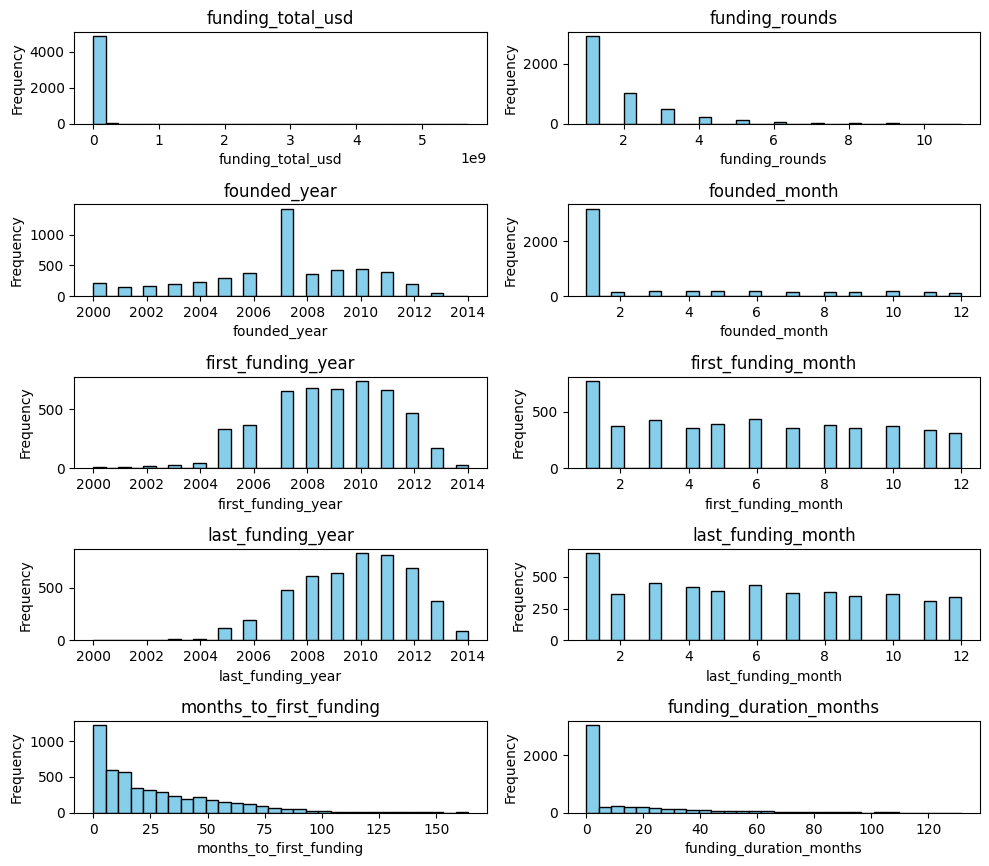

In [40]:
plt.figure(figsize=(10, 60))

for i, col in enumerate(numerical_att, 1):
    plt.subplot(35, 2, i)
    plt.hist(df_final[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

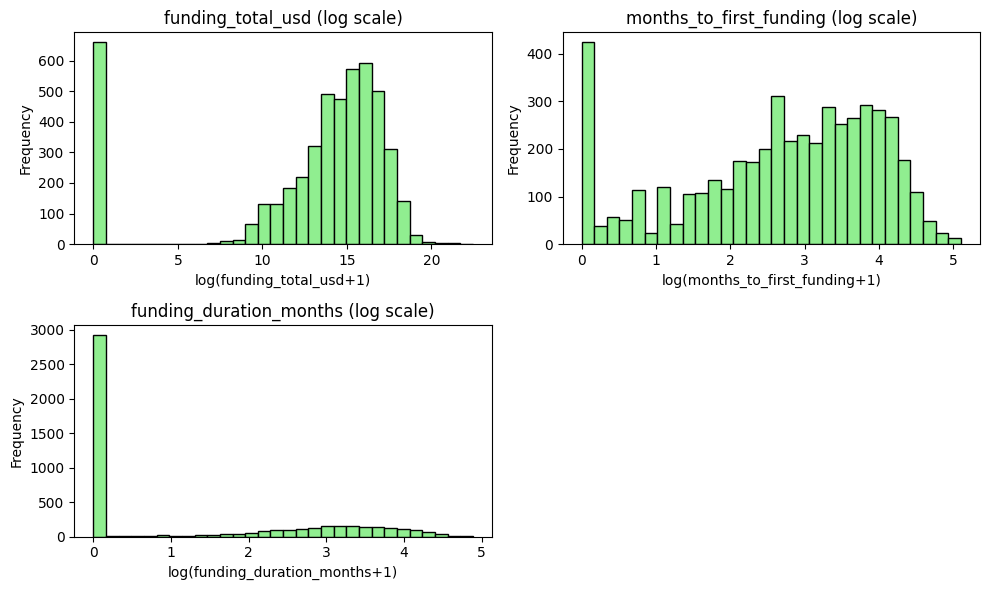

In [41]:
log_treatment = ['funding_total_usd', 'months_to_first_funding', 'funding_duration_months']

plt.figure(figsize=(10, 6))

for i, col in enumerate(log_treatment, 1):
    plt.subplot(2, 2, i)
    plt.hist(np.log1p(df_final[col]), bins=30, color='lightgreen', edgecolor='black')
    plt.title(f'{col} (log scale)')
    plt.xlabel(f'log({col}+1)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [42]:
# Applying log1p transformation to selected columns
for col in log_treatment:
    df_final[col] = np.log1p(df_final[col])


### **6. Exploratory Data Analysis (EDA)**
----

#### **6.1. Failure Distribution in Dataset**
----

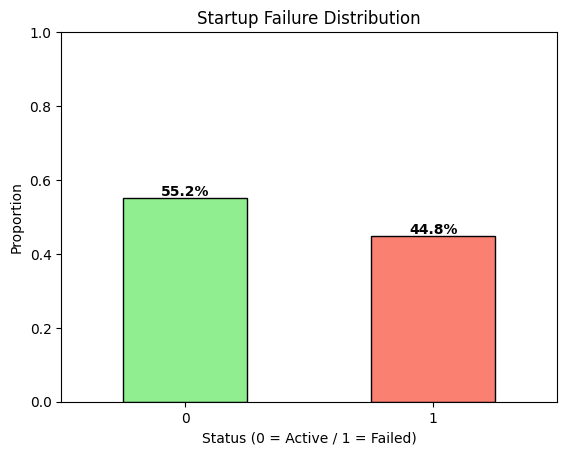

In [43]:
# The proportion of failed vs active startups in the dataset:

proportions = df_final['failed'].value_counts(normalize=True)

ax = proportions.plot(
    kind='bar',
    color=['lightgreen', 'salmon'],
    edgecolor='black'
)

plt.title('Startup Failure Distribution')
plt.xlabel('Status (0 = Active / 1 = Failed)')
plt.ylabel('Proportion')
plt.xticks(rotation=0)

for i, v in enumerate(proportions):
    plt.text(i, v + 0.005, f"{v*100:.1f}%", ha='center', fontweight='bold')

plt.ylim(0, 1)
plt.show()

#### **6.2. Distribution of Numerical Features**
----

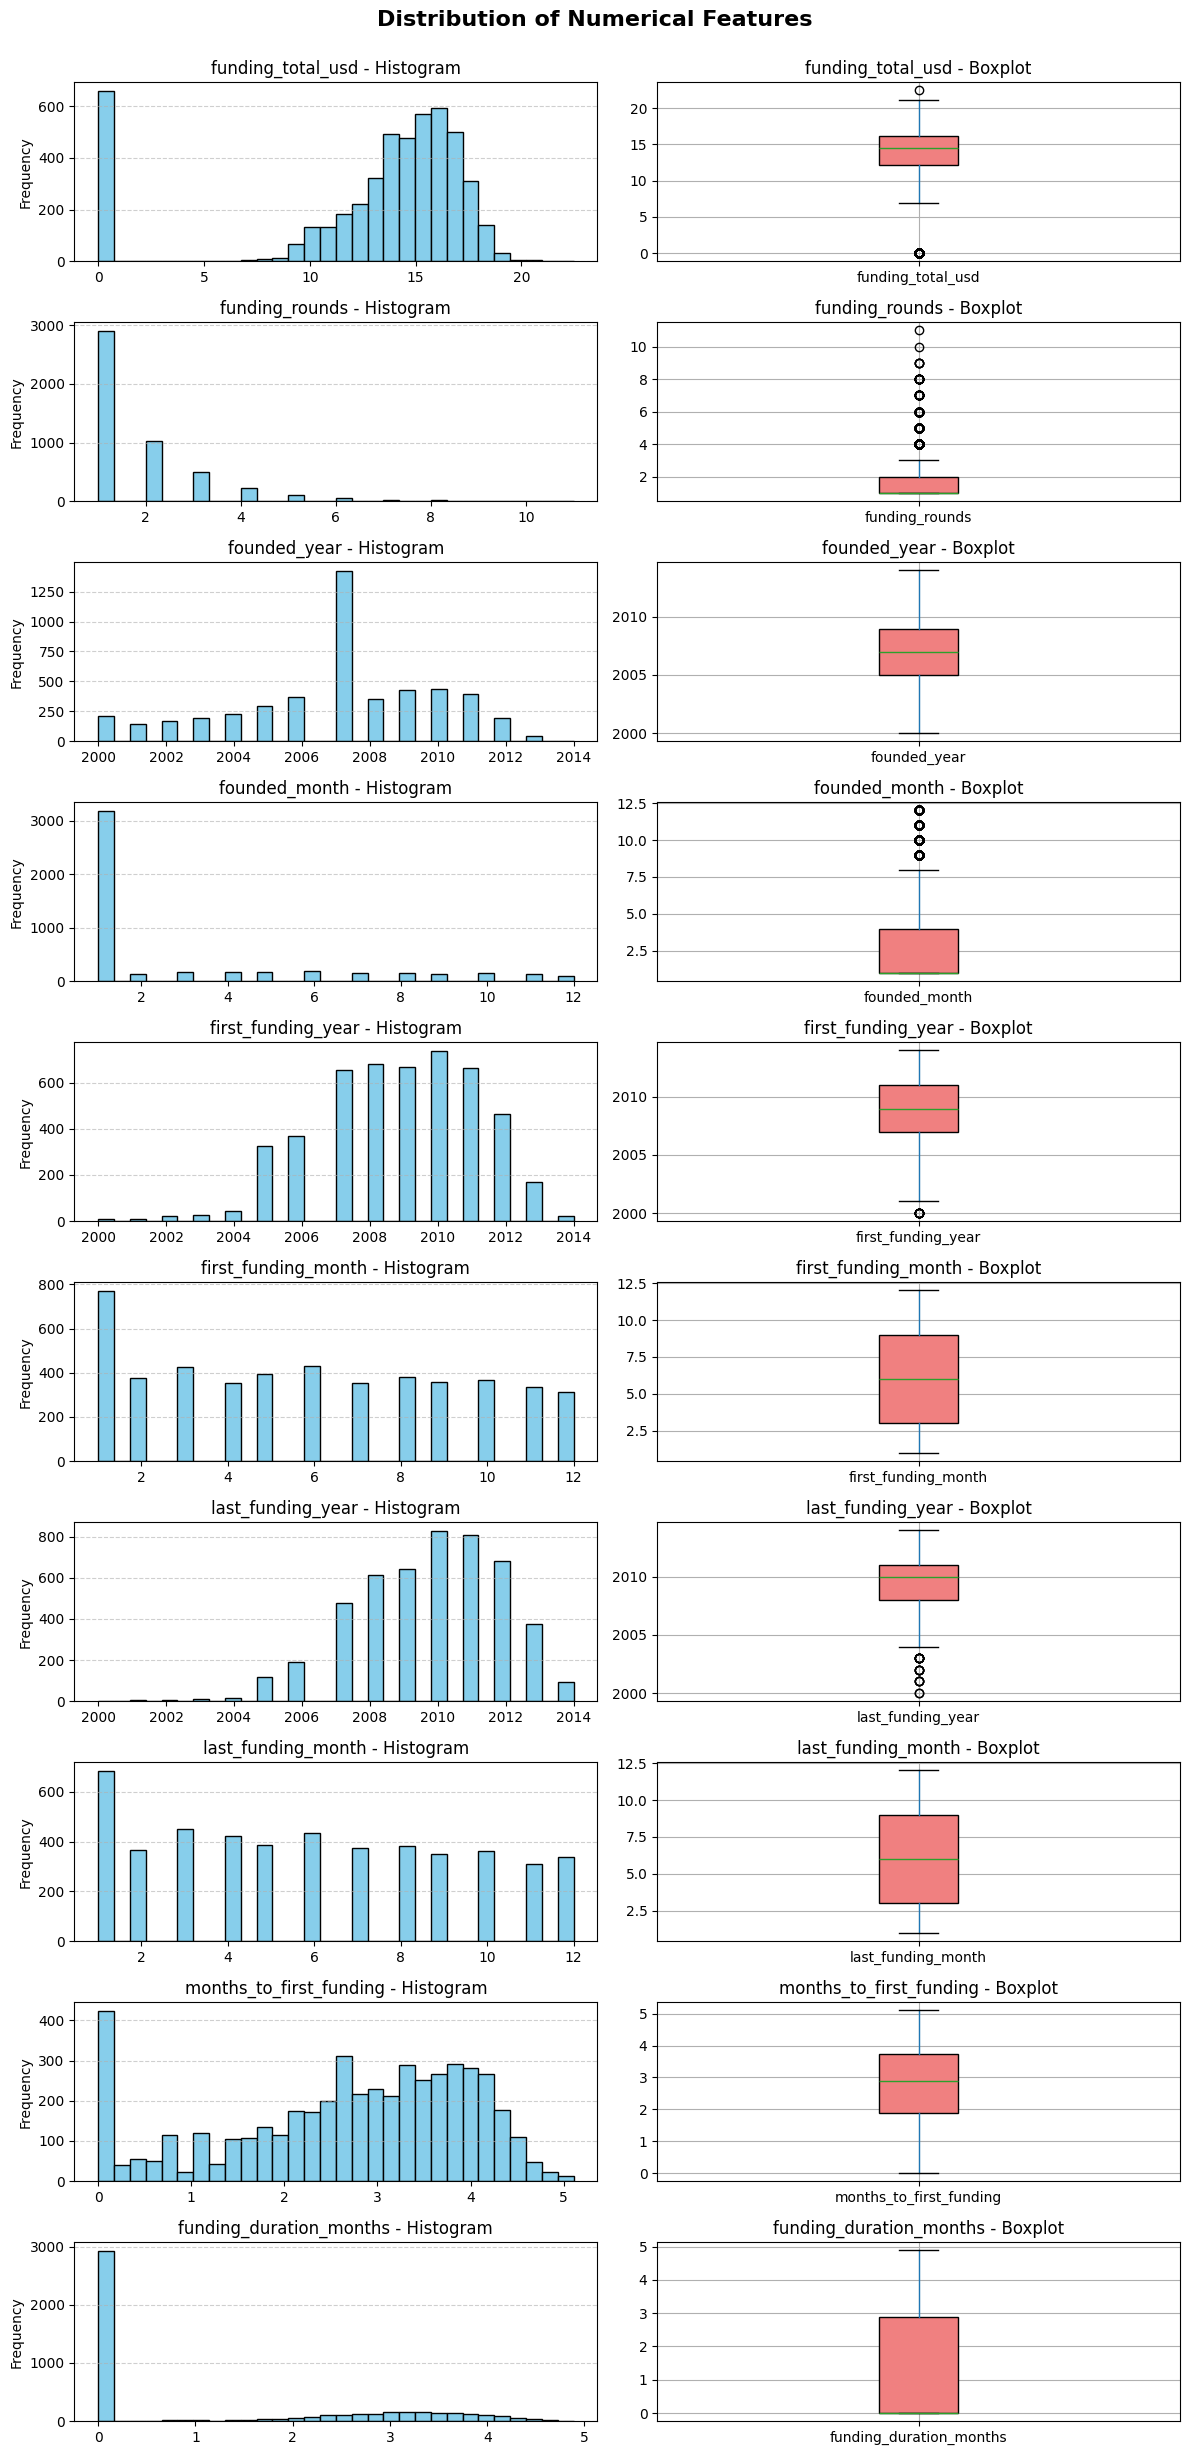

In [44]:
fig, axes = plt.subplots(nrows=len(numerical_att), ncols=2, figsize=(12, len(numerical_att)*2.5))
fig.suptitle('Distribution of Numerical Features', fontsize=16, fontweight='bold')


for i, col in enumerate(numerical_att):
    df_final[col].plot(kind='hist', bins=30, ax=axes[i, 0], color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f'{col} - Histogram')
    axes[i, 0].set_xlabel('')
    axes[i, 0].grid(axis='y', linestyle='--', alpha=0.6)
    
    df_final.boxplot(column=col, ax=axes[i, 1], patch_artist=True, boxprops=dict(facecolor='lightcoral'))
    axes[i, 1].set_title(f'{col} - Boxplot')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# The histograms show how each numerical feature is distributed.
# Most monetary and duration-related variables are right-skewed, which is typical for startup data.
# Since we already applied log1p to some of them, this helps to normalize the scale for the logistic regression model.

# The boxplots reveal the presence of outliers, but since they are meaningful in this context (e.g., exceptionally funded startups), they are not removed.

#### **6.3 Relationship Between Numerical Features and Failure**
----

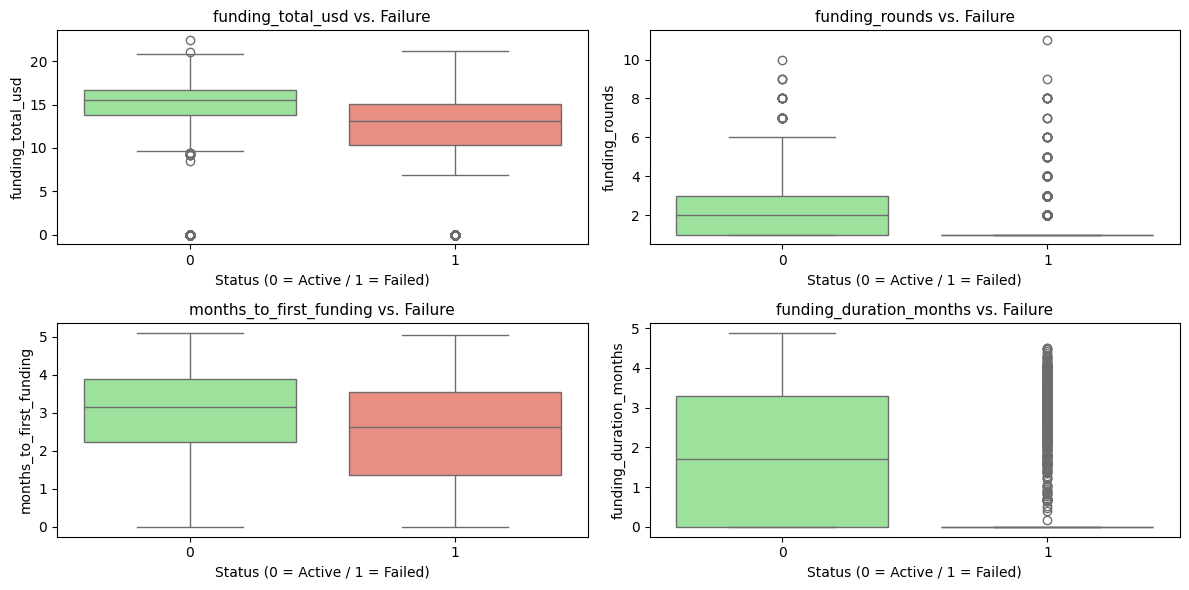

In [45]:
numerical_comp = [
    'funding_total_usd',
    'funding_rounds',
    'months_to_first_funding',
    'funding_duration_months'
]

plt.figure(figsize=(12, len(numerical_comp)*1.5))
for i, col in enumerate(numerical_comp, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(
        data=df_final,
        x='failed',           
        y=col,
        hue='failed',         
        dodge=False,          
        palette={0: 'lightgreen', 1: 'salmon'},
        legend=False
    )
    plt.title(f'{col} vs. Failure', fontsize=11)
    plt.xlabel('Status (0 = Active / 1 = Failed)')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

# Insights from Numerical Features vs Failure:
# > funding_total_usd: Startups that survived consistently received higher funding, indicating more funding reduces the chance of failure.
# > funding_rounds: Failed startups mostly had only 1 funding round, while successful ones had multiple rounds, showing maturity matters.
# > months_to_first_funding: Surviving startups took slightly longer to get the first funding, suggesting rapid early funding doesn’t guarantee success.
# > funding_duration_months: Failed startups clustered around very short durations, while successful ones show more dispersion, indicating healthy time between rounds supports survival.
# Overall: Financial features clearly differentiate failed vs. successful startups and are strong predictors for the logistic regression model. Outliers are meaningful and should be kept.

#### **6.4 Relationship Between Categorical Features and Failure**
----

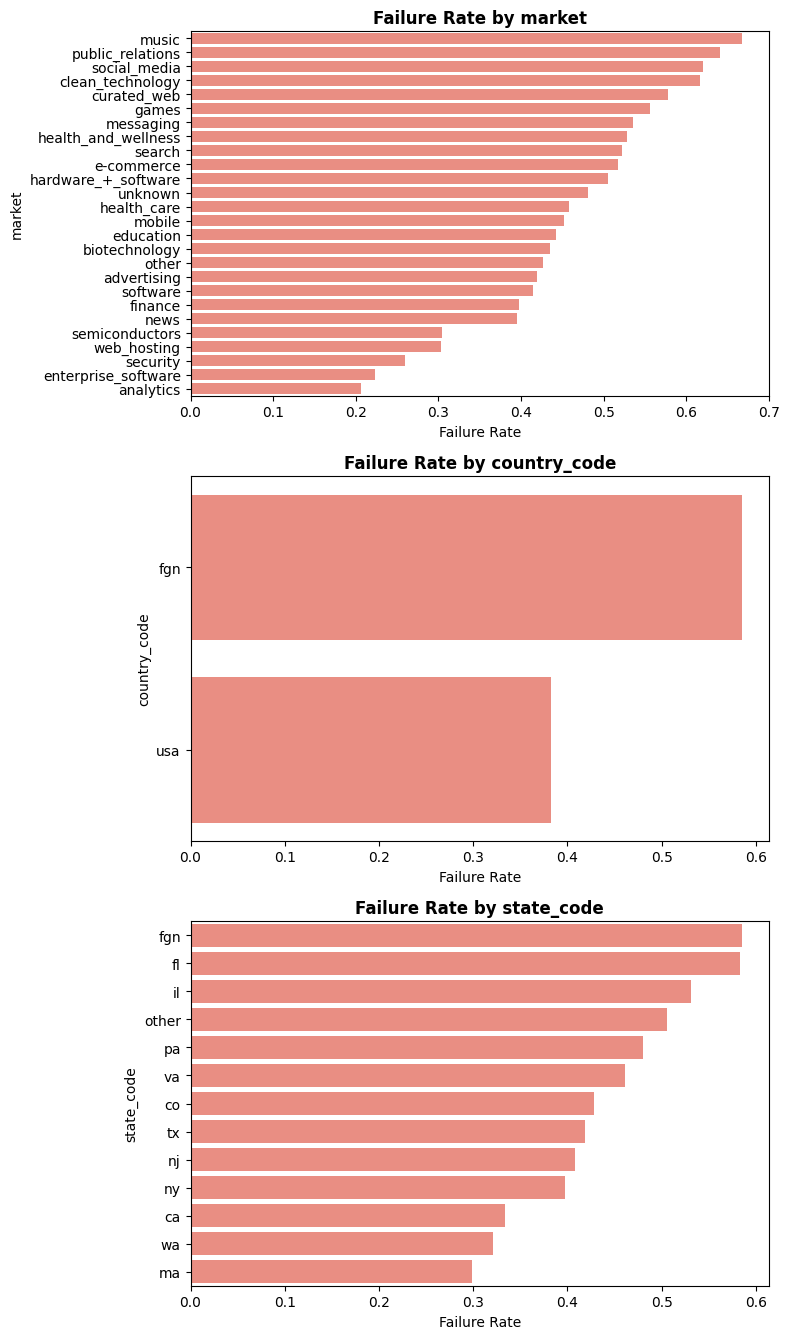

In [46]:
plt.figure(figsize=(8, len(categorical)*4.5))
for i, col in enumerate(categorical, 1):
    plt.subplot(3, 1, i)
    
    cat_rates = df_final.groupby(col)['failed'].mean().sort_values(ascending=False)
    
    sns.barplot(
        x=cat_rates.values,
        y=cat_rates.index,
        color='salmon'
    )

    
    plt.title(f'Failure Rate by {col}', fontsize=12, fontweight='bold')
    plt.xlabel('Failure Rate')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

# Insights from Categorical Features vs Failure:
# Startups from the US show a lower failure rate (39%) compared to foreign ones (59%).
# Among US states, Florida (58%) and Illinois (53%) show slightly higher failure rates.
# Regarding markets, sectors like Music (68%), Public Relations (65%), Social Media, and Clean Technology (61%) exhibit the highest failure rates.


### **7. Preparing the Dataset**
----

In [47]:
def split_dataset(df, target_col='failed', test_size=0.2, val_size=0.25, random_state=1):

    df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    df_train, df_val       = train_test_split(df_full_train, test_size=val_size, random_state=random_state)
    
    for d in [df_full_train, df_train, df_val, df_test]:
        d.reset_index(drop=True, inplace=True)
    
    y_full_train = df_full_train[target_col].values
    y_train      = df_train[target_col].values
    y_val        = df_val[target_col].values
    y_test       = df_test[target_col].values
    
    for d in [df_full_train, df_train, df_val, df_test]:
        d.drop(columns=[target_col], inplace=True)
    
    df_splits = {
        'full_train': df_full_train,
        'train': df_train,
        'val': df_val,
        'test': df_test
    }
    
    y_splits = {
        'full_train': y_full_train,
        'train': y_train,
        'val': y_val,
        'test': y_test
    }
    
    return df_splits, y_splits

In [48]:
df_splits, y_splits = split_dataset(df_final)

df_full_train = df_splits['full_train']
df_train      = df_splits['train']
df_val        = df_splits['val']
df_test       = df_splits['test']

y_full_train  = y_splits['full_train']
y_train       = y_splits['train']
y_val         = y_splits['val']
y_test        = y_splits['test']

### **8. Normalization and Standardization**
----

In [49]:
def scale_datasets(datasets, cols):
    scaler = StandardScaler()
    scaled_sets = {}

    scaler.fit(datasets['train'][cols])

    for name, df in datasets.items():
        scaled_sets[name] = df.copy()
        scaled_sets[name][cols] = scaler.transform(df[cols])

    return scaled_sets, scaler


In [50]:
dfs = {
    'train': df_train,
    'val': df_val,
    'test': df_test,
    'full_train': df_full_train
}

scaled, scaler = scale_datasets(dfs, numerical_att)

df_train_scaled      = scaled['train']
df_val_scaled        = scaled['val']
df_test_scaled       = scaled['test']
df_full_train_scaled = scaled['full_train']

### **9. One-Hot Encoding**
----

In [51]:
def encode_with_dv(df_splits, categorical, numerical):
    cols = categorical + numerical
    
    dicts = {name: df[cols].to_dict(orient='records') for name, df in df_splits.items()}
    
    dv = DictVectorizer(sparse=False)
    dv.fit(dicts['train'])
    
    X_splits = {name: dv.transform(dicts[name]) for name in dicts}
    
    return X_splits, dv

In [52]:
X_splits, dv = encode_with_dv(df_splits, categorical, numerical_att)

X_train      = X_splits['train']
X_val        = X_splits['val']
X_test       = X_splits['test']
X_full_train = X_splits['full_train']

### **10. Logistic Regression (Model 1)**
----

In [53]:
def train_and_evaluate(X_train, y_train, X_val, y_val, C=1.0, max_iter=1000, random_state=42, class_weight="balanced", label="Validation"):

    model = LogisticRegression(
        C=C,
        max_iter=max_iter,
        random_state=random_state,
        class_weight=class_weight
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba)
    cm = confusion_matrix(y_val, y_pred)
    
    print(f"\n{label} Accuracy: {acc:.3f}")
    print(f"{label} AUC: {auc:.3f}")
    print(f"{label} Confusion Matrix:\n{cm}")
    
    return model, {"accuracy": acc, "auc": auc, "confusion_matrix": cm}

In [54]:
model, metrics = train_and_evaluate(
    X_train, y_train, X_val, y_val,
    C=1.0,
    max_iter=10000,
    random_state=42,
    class_weight='balanced',
    label="Validation"
)


Validation Accuracy: 0.681
Validation AUC: 0.749
Validation Confusion Matrix:
[[321 186]
 [125 342]]


### **11. K-Fold Validation**
----

In [55]:
def run_kfold(df, target_col, categorical, numerical, n_splits=5, C=1.0, max_iter=1000, random_state=42):

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = []

    fold = 1
    for train_idx, val_idx in kfold.split(df):
        print(f"\n===== Fold {fold} =====")

        df_train = df.iloc[train_idx].copy()
        df_val   = df.iloc[val_idx].copy()

        y_train = df_train[target_col].values
        y_val   = df_val[target_col].values

        df_train = df_train.drop(columns=[target_col])
        df_val   = df_val.drop(columns=[target_col])

        df_splits = {'train': df_train, 'val': df_val}
        scaled_sets, scaler = scale_datasets(df_splits, numerical)
        X_splits, dv = encode_with_dv(scaled_sets, categorical, numerical)

        model, metrics = train_and_evaluate(
            X_splits['train'],
            y_train,
            X_splits['val'],
            y_val,
            C=C,
            max_iter=max_iter,
            random_state=random_state,
            label=f"Fold {fold}"
        )

        scores.append(metrics["auc"])
        fold += 1

    print("\n===== K-FOLD RESULTS =====")
    print(f"Mean AUC: {np.mean(scores):.3f} ± {np.std(scores):.3f}")


In [56]:
run_kfold(
    df=df_final,
    target_col='failed',
    categorical=categorical,
    numerical=numerical_att,
    n_splits=5,
    C=1.0,
    max_iter=10000
)

# The 5-fold cross-validation results are stable, with a mean AUC of 0.742 ± 0.015.
# The small variation across folds indicates good generalization and no signs of overfitting.
# As a baseline Logistic Regression model, the performance is solid.


===== Fold 1 =====

Fold 1 Accuracy: 0.664
Fold 1 AUC: 0.719
Fold 1 Confusion Matrix:
[[349 189]
 [138 298]]

===== Fold 2 =====



Fold 2 Accuracy: 0.668
Fold 2 AUC: 0.740
Fold 2 Confusion Matrix:
[[341 186]
 [137 310]]

===== Fold 3 =====

Fold 3 Accuracy: 0.701
Fold 3 AUC: 0.755
Fold 3 Confusion Matrix:
[[352 161]
 [130 330]]

===== Fold 4 =====

Fold 4 Accuracy: 0.670
Fold 4 AUC: 0.731
Fold 4 Confusion Matrix:
[[362 184]
 [137 290]]

===== Fold 5 =====

Fold 5 Accuracy: 0.694
Fold 5 AUC: 0.762
Fold 5 Confusion Matrix:
[[379 182]
 [116 296]]

===== K-FOLD RESULTS =====
Mean AUC: 0.742 ± 0.015


### **12. Tuning of Hyperparameters**
----

In [57]:
C_values = [0.01, 0.1, 1, 10]
penalties = ['l1', 'l2']
results = []

In [58]:
for C, penalty in product(C_values, penalties):
    print(f"\n===== Training model with C={C}, penalty={penalty} =====")

    try:
        model, metrics = train_and_evaluate(
            X_train, y_train,
            X_val, y_val,
            C=C,
            max_iter=10000,
            random_state=42,
            class_weight='balanced',
            label=f"Validation (C={C}, penalty={penalty})"
        )

        results.append({
            'C': C,
            'penalty': penalty,
            'AUC': metrics['auc'],
            'Accuracy': metrics['accuracy']
        })

    except Exception as e:
        print(f"⚠️ Error with C={C}, penalty={penalty}: {e}")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='AUC', ascending=False).reset_index(drop=True)

print("\n===== Summary of Parameter Tuning =====")
display(results_df)

# The best performing configuration was C = 0.1 (either L1 or L2 penalty).
# AUC improved slightly (~0.755), showing good model stability across regularization types.
# Since L1 and L2 yielded the same results, we will proceed with L2 (default) for simplicity.


===== Training model with C=0.01, penalty=l1 =====



Validation (C=0.01, penalty=l1) Accuracy: 0.693
Validation (C=0.01, penalty=l1) AUC: 0.753
Validation (C=0.01, penalty=l1) Confusion Matrix:
[[320 187]
 [112 355]]

===== Training model with C=0.01, penalty=l2 =====

Validation (C=0.01, penalty=l2) Accuracy: 0.693
Validation (C=0.01, penalty=l2) AUC: 0.753
Validation (C=0.01, penalty=l2) Confusion Matrix:
[[320 187]
 [112 355]]

===== Training model with C=0.1, penalty=l1 =====

Validation (C=0.1, penalty=l1) Accuracy: 0.694
Validation (C=0.1, penalty=l1) AUC: 0.755
Validation (C=0.1, penalty=l1) Confusion Matrix:
[[324 183]
 [115 352]]

===== Training model with C=0.1, penalty=l2 =====

Validation (C=0.1, penalty=l2) Accuracy: 0.694
Validation (C=0.1, penalty=l2) AUC: 0.755
Validation (C=0.1, penalty=l2) Confusion Matrix:
[[324 183]
 [115 352]]

===== Training model with C=1, penalty=l1 =====

Validation (C=1, penalty=l1) Accuracy: 0.681
Validation (C=1, penalty=l1) AUC: 0.749
Validation (C=1, penalty=l1) Confusion Matrix:
[[321 186]

,C,penalty,AUC,Accuracy
0,0.10,l2,0.755242,0.694045
1,0.10,l1,0.755242,0.694045
2,0.01,l2,0.752920,0.693018
3,0.01,l1,0.752920,0.693018
4,1.00,l1,0.749397,0.680698
5,1.00,l2,0.749397,0.680698
6,10.00,l1,0.747087,0.680698
7,10.00,l2,0.747087,0.680698


### **13. Final Logistic Regression (Full Train)**
----

In [59]:
C_final = 0.1
penalty_final = 'l2'
max_iter_final = 10000
random_state_final = 42

final_model = LogisticRegression(
    C=C_final,
    penalty=penalty_final,
    max_iter=max_iter_final,
    random_state=random_state_final,
    class_weight='balanced'
)

final_model.fit(X_full_train, y_full_train)

y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_test_pred)
auc_test = roc_auc_score(y_test, y_test_proba)
cm_test = confusion_matrix(y_test, y_test_pred)

print(f"Test Accuracy: {acc_test:.3f}")
print(f"Test AUC: {auc_test:.3f}")
print("Test Confusion Matrix:")
print(cm_test)

# The final logistic regression model was trained on the full training set
# using C=0.1 and L2 penalty. The model shows stable performance on the test set,
# with good discrimination (AUC) and balanced accuracy.
# Confusion matrix indicates reasonable separation between failed and active startups.


Test Accuracy: 0.691
Test AUC: 0.757
Test Confusion Matrix:
[[360 188]
 [113 313]]


### **14. Evaluation of the final model**
----

In [60]:
y_pred_proba = model.predict_proba(X_test)[:,1]

fig_roc, ax_roc = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax_roc)
ax_roc.set_title(f"ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})")
fig_roc.tight_layout()
fig_roc.savefig("images/roc_curve.png", dpi=300, bbox_inches='tight')
plt.close(fig_roc)

fig_hist, ax_hist = plt.subplots(figsize=(5,5))
ax_hist.hist([y_pred_proba[y_test==0], y_pred_proba[y_test==1]],
             bins=20, color=['lightgreen','salmon'], label=['Active','Failed'], alpha=0.7)
ax_hist.set_title("Predicted Probabilities")
ax_hist.set_xlabel("Predicted Probability")
ax_hist.set_ylabel("Count")
ax_hist.legend()
fig_hist.tight_layout()
fig_hist.savefig("images/pred_probs.png", dpi=300, bbox_inches='tight')
plt.close(fig_hist)

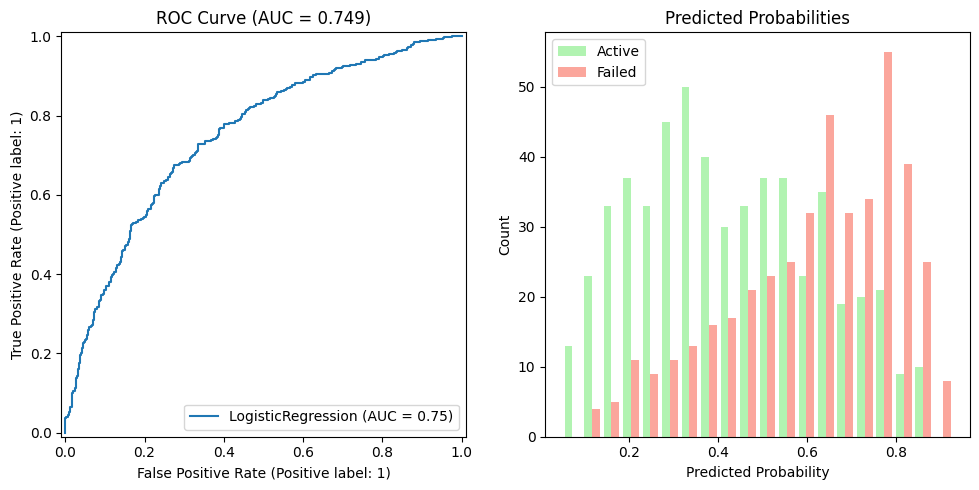

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[0])
axes[0].set_title(f"ROC Curve (AUC = {roc_auc_score(y_test, model.predict_proba(X_test)[:,1]):.3f})")

axes[1].hist([y_pred_proba[y_test==0], y_pred_proba[y_test==1]],
             bins=20, color=['lightgreen','salmon'], label=['Active','Failed'], alpha=0.7)
axes[1].set_title("Predicted Probabilities")
axes[1].set_xlabel("Predicted Probability")
axes[1].set_ylabel("Count")
axes[1].legend()

plt.tight_layout()
plt.show()

# The ROC curve shows the model's ability to distinguish between active and failed startups. 
# With an AUC of 0.749, the model demonstrates decent discriminatory power. A perfect model 
# would reach the top-left corner.

# The histogram displays the predicted probabilities for both classes. Ideally, we would see 
# two well-separated peaks: one near 0 for active startups and one near 1 for failed startups. 
# Here, the peaks are distinguishable but with some overlap, indicating the model correctly 
# predicts most cases but has some uncertainty.

In [62]:
y_probs = model.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10, strategy='uniform')

fig_pr, ax_pr = plt.subplots(figsize=(5,5))
PrecisionRecallDisplay.from_predictions(y_test, y_probs, ax=ax_pr, color='darkorange')
ax_pr.set_title("Precision-Recall Curve")
fig_pr.tight_layout()
fig_pr.savefig("images/precision_recall_curve.png")
plt.close(fig_pr)

fig_cal, ax_cal = plt.subplots(figsize=(5,5))
ax_cal.plot([0,1], [0,1], "k:", label="Perfectly calibrated")
ax_cal.plot(prob_pred, prob_true, "s-", label="Logistic Regression", color='navy')
ax_cal.set_title("Calibration Curve")
ax_cal.set_xlabel("Mean Predicted Probability")
ax_cal.set_ylabel("Fraction of Positives")
ax_cal.legend()
fig_cal.tight_layout()
fig_cal.savefig("images/calibration_curve.png")
plt.close(fig_cal)

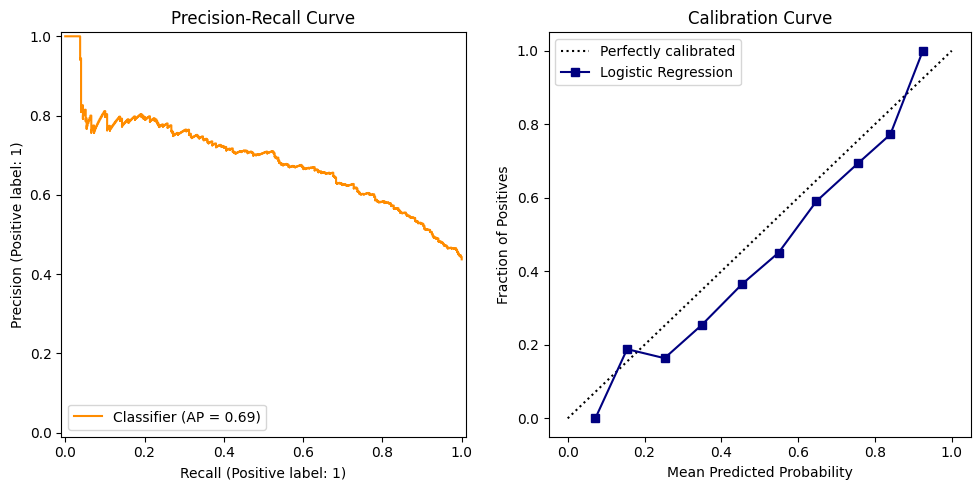

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# 1. Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_probs, ax=axes[0], color='darkorange')
axes[0].set_title("Precision-Recall Curve")

# 2. Calibration Curve

axes[1].plot([0,1], [0,1], "k:", label="Perfectly calibrated")
axes[1].plot(prob_pred, prob_true, "s-", label="Logistic Regression", color='navy')
axes[1].set_title("Calibration Curve")
axes[1].set_xlabel("Mean Predicted Probability")
axes[1].set_ylabel("Fraction of Positives")
axes[1].legend()

plt.tight_layout()
plt.show()

# The PR curve shows the trade-off between precision and recall. We see an initial plateau at 
# high precision for low recall thresholds, typical in datasets with some class imbalance.

# The calibration curve compares predicted probabilities to observed outcomes. Our model is 
# slightly under-confident, with predicted probabilities generally a bit below the actual fraction 
# of positives.

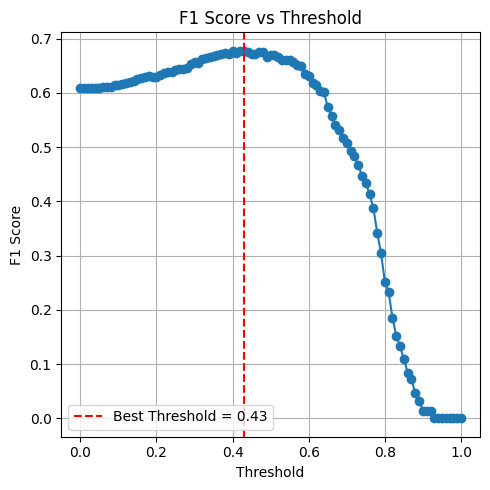

In [64]:
thresholds = np.linspace(0, 1, 101)
f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(thresholds, f1_scores, marker='o')
ax.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
ax.set_title('F1 Score vs Threshold')
ax.set_xlabel('Threshold')
ax.set_ylabel('F1 Score')
ax.grid(True)
ax.legend()

fig.tight_layout()
fig.savefig("images/f1_score_vs_threshold.png")
plt.show()

# This plot shows how F1 score varies with different thresholds. The vertical line indicates the 
# threshold that maximizes F1, which can be used for decision-making in production. In our case,
# we found 0.43; however, we will set it to 0.5 because we already have a model with more 
# sensitive detection.

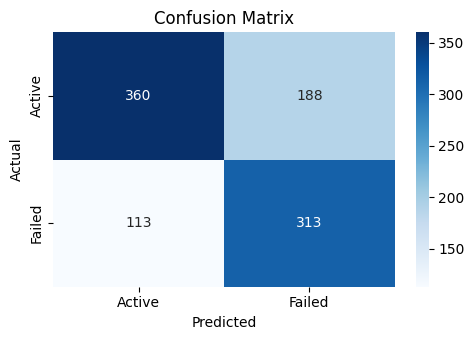

In [65]:
cm = confusion_matrix(y_test, y_test_pred)
labels = ['Active', 'Failed']

fig, ax = plt.subplots(figsize=(5,3.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

fig.tight_layout()
fig.savefig("images/confusion_matrix.png")
plt.show()

### **15. Saving and Deploying the Model**
----

In [66]:
import pickle

In [67]:
output_file = f'model_C={C_final}.bin'

with open(output_file, 'wb') as f_out:
    pickle.dump((dv, scaler, final_model), f_out)

In [68]:
model_file = 'model_C=0.1.bin'
with open(model_file, 'rb') as f_in:
    dv, scaler, final_model = pickle.load(f_in)

In [69]:
sample = df_final.iloc[[3]].copy()
sample

,market,funding_total_usd,country_code,state_code,funding_rounds,failed,founded_missing,founded_year,founded_month,first_funding_year,first_funding_month,last_funding_year,last_funding_month,months_to_first_funding,funding_duration_months,received_seed,received_venture,received_equity_crowdfunding,received_undisclosed,received_convertible_note,received_debt_financing,received_angel,received_grant,received_private_equity,received_post_ipo_equity,received_post_ipo_debt,received_secondary_market,received_product_crowdfunding
27,analytics,14.038655,usa,ca,2.0,0,0,2011.0,9.0,2011,11,2011,11,1.131402,0.641854,1,1,0,0,0,0,0,0,0,0,0,0,0


In [70]:
sample_scaled = sample.copy()
sample_scaled[numerical_att] = scaler.transform(sample[numerical_att])

sample_dict = sample_scaled[categorical + numerical_att].to_dict(orient='records')
X_sample = dv.transform(sample_dict)

pred_proba = final_model.predict_proba(X_sample)[0, 1]
pred_label = (pred_proba >= 0.5).astype(int)

print(f"Predicted probability of failure: {pred_proba:.3f}")
print(f"Predicted label: {pred_label}")

Predicted probability of failure: 0.346
Predicted label: 0
